**What**: We need to be able to take a screenshot and detect whether it's the the starmap view in your "mobi glass."

# Code Setup

In [1]:
import os
from pathlib import Path
from PIL import Image
import torch
import fastai
import fastai.vision as vision
from fastai.vision.all import *

# note: importing manually as below resulted in errors when trying to call
# learner.fine_tune().
#from fastai.vision.data import ImageDataLoaders, DataBlock, ImageBlock, CategoryBlock, get_image_files
#from fastai.vision.data import RandomSplitter, parent_label, imagenet_stats
#from fastai.vision.augment import Resize, aug_transforms, Normalize
#from fastai.metrics import error_rate
#from fastai.vision.learner import vision_learner
#from fastai.vision import models

In [3]:
assert torch.cuda.is_available()

## Data preparation

In [2]:
data_path = Path('data/screenshots')
assert os.path.exists(data_path/'starmap')
assert os.path.exists(data_path/'other')

In [3]:
print(f"Number of images in 'starmap': {len(list((data_path/'starmap').glob('*.jpg')))}")
print(f"Number of images in 'other': {len(list((data_path/'other').glob('*.jpg')))}")

Number of images in 'starmap': 12
Number of images in 'other': 40


In [51]:
# dls = ImageDataLoaders.from_folder(
#     data_path,
#     valid_pct=0.2,          # 20% of data for validation
#     seed=1982,              # For reproducibility
#     item_tfms=Resize(224),  # Resize images to 224x224
#     batch_size=16
# )

## Approach 1: Cropping screenshots

We need to crop only the region of the image that contains the coordinates. It's located above the mobi glass dock at the bottom.

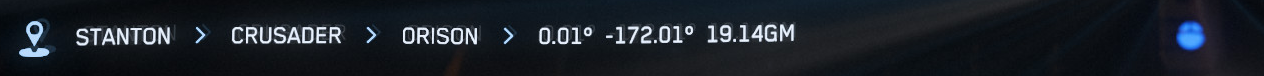

In [29]:
from torchvision.transforms.functional import crop

def crop_region(img):
    # I got the rect from IrfanView, which helpfully displays selection rect
    # in the window title bar
    h, w = img.shape
    # crop_w, crop_h = 1207, 64
    # top = 1178
    # left = 167
    crop_w, crop_h = 1054, 49
    top = 1192
    left = 172
    return crop(img, top=top, left=left, height=crop_h, width=crop_w)

We create a transform to crop and then resize the image. The resize 'method' was chosen because it may

<Axes: >

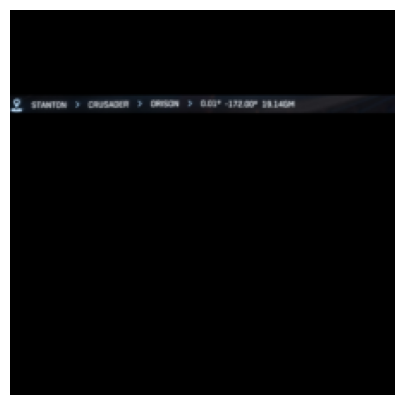

In [35]:
starmap_images = list((data_path/'starmap').glob('*.jpg'))
sm_test_image = PILImage.create(starmap_images[0])
crop_tfm = Pipeline([
    lambda img: crop_region(img),
    #Resize(224, method='squish', resamples=(Image.BILINEAR, Image.NEAREST))
    Resize(224, method='pad', pad_mode='zeros', resamples=(Image.BILINEAR, Image.NEAREST))
])
sm_test_image_cropped = crop_tfm(sm_test_image)
sm_test_image_cropped.show()

In [38]:
screenshots_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=1982),
    get_y=parent_label,
    item_tfms=Resize(224, method='pad', pad_mode='zeros', resamples=(Image.BILINEAR, Image.NEAREST)),
    batch_tfms=[*aug_transforms(size=244), Normalize.from_stats(*imagenet_stats)]
)
loaders = screenshots_block.dataloaders(data_path, bs=4)

Successfully created dataloaders!
Classes: ['other', 'starmap']


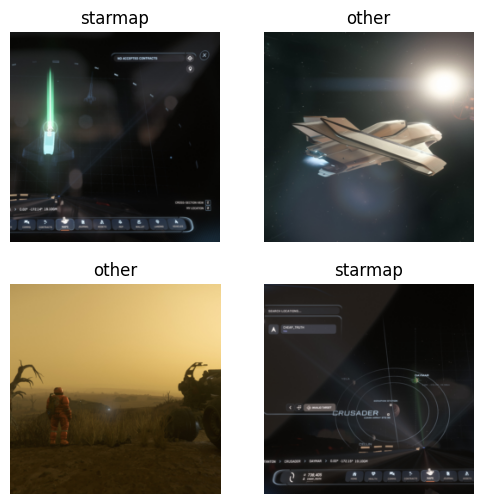

In [8]:
# let's verify
# Try to create a small sample of the data to debug
try:
    dls = screenshots_block.dataloaders(data_path, bs=4)
    print("Successfully created dataloaders!")
    print(f"Classes: {dls.vocab}")
    dls.show_batch()
except Exception as e:
    print(f"Error creating dataloaders: {e}")

# screenshots_block.summary(data_path)

### Training

In [42]:
learn = vision_learner(loaders, models.resnet34, metrics=error_rate)
learn.fine_tune(5, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.274106,0.952486,0.300000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.993492,0.673783,0.300000,00:03
1,0.914843,0.107691,0.000000,00:02
2,0.842006,0.188346,0.200000,00:03
3,0.948790,0.165321,0.100000,00:02
4,0.983478,0.241910,0.100000,00:03


Note that our we had best performance on epoch 1.

Now, let's look at the misclassified images.

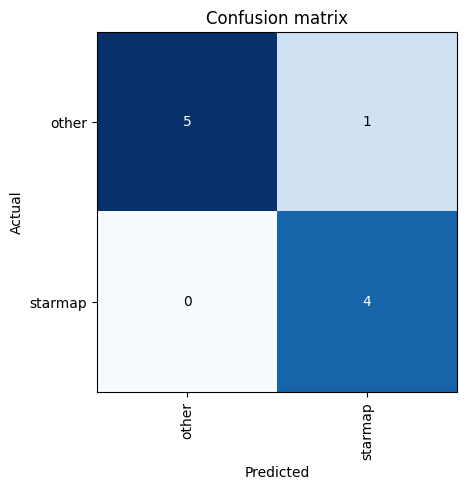

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

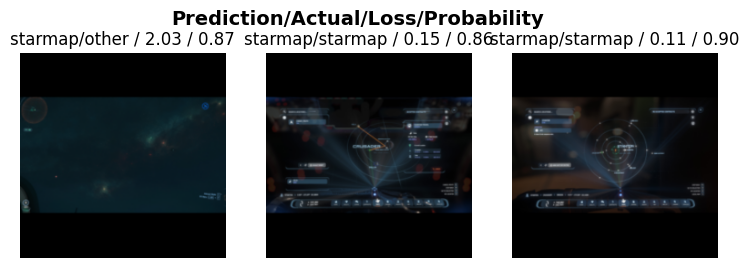

In [44]:
interp.plot_top_losses(3)

As noted above, we had the best performance after 2 epochs of training.

One of the ways to save the best version of the model is via a callback:

```python
learn.fine_tune(
    4, 
    3e-3,
    cbs=[
        SaveModelCallback(monitor='valid_loss', fname='screenshot_classifier_best')
    ]
)
```

In [53]:
learner_best = vision_learner(loaders, models.resnet34, metrics=error_rate)

learner_best.fit_one_cycle(1, 3e-3)
learner_best.fine_tune(1, 3e-3)

learner_best.save('sc_starmap_cropped_e1')

epoch,train_loss,valid_loss,error_rate,time
0,1.015234,0.643748,0.400000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.744379,0.298922,0.300000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.552531,0.159246,0.100000,00:03


Path('models/sc_starmap_cropped_e1.pth')

## Approach 2: No cropping

Let's see what results we get if we use the whole screenshots (resized to fit the resnet model).

<Axes: >

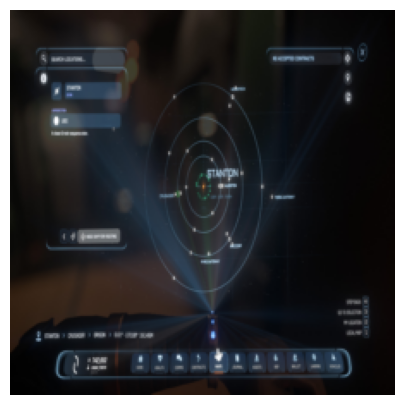

In [15]:
squish_tfm = Pipeline([
    #Resize(224, method='squish', resamples=(Image.BILINEAR, Image.NEAREST))
    Resize(224, method='squish', resamples=(Image.BILINEAR, Image.NEAREST))
])
sm_test_image_squished = crop_tfm(sm_test_image)
sm_test_image_squished.show()

In [54]:
screenshots_block_2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=1982),
    get_y=parent_label,
    item_tfms=squish_tfm,
    batch_tfms=[*aug_transforms(size=244), Normalize.from_stats(*imagenet_stats)]
)
loaders_2 = screenshots_block.dataloaders(data_path, bs=4)

In [55]:
learn_2 = vision_learner(loaders_2, models.resnet34, metrics=error_rate)
learn_2.fine_tune(5, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.107629,0.884346,0.300000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.921027,0.203332,0.100000,00:03
1,1.147935,0.178231,0.000000,00:02
2,0.947206,0.191333,0.100000,00:03
3,0.835287,0.114761,0.000000,00:02
4,0.724366,0.087149,0.000000,00:03


In [56]:
learn_2.save('sc_starmap_squished_e4')

Path('models/sc_starmap_squished_e4.pth')

## Using the trained model

In [59]:
usable_learn = vision_learner(loaders_2, models.resnet34, metrics=error_rate)
usable_learn.load('sc_starmap_squished_e4', weights_only=False)

# Make predictions
#img = PILImage.create('path/to/test/image.jpg')
#pred_class,pred_idx,probs = learn.predict(img)
#print(f"Prediction: {pred_class}")
#print(f"Probability: {probs[pred_idx]:.4f}")

## Debugging problems (scratchpad)

In [70]:
# debugging why dataloaders fails
starmap_files = list((data_path/'starmap').glob('*'))
other_files = list((data_path/'other').glob('*'))
for i, img_path in enumerate(other_files[:3]):
    try:
        img = Image.open(img_path)
        print(f"Successfully opened starmap image {i+1}: {img_path.name}, size: {img.size}, mode: {img.mode}")
    except Exception as e:
        print(f"Error opening starmap image {i+1}: {img_path.name}, error: {e}")


Successfully opened starmap image 1: ScreenShot-2024-08-03_22-28-31-6D7.jpg, size: (2560, 1440), mode: RGB
Successfully opened starmap image 2: ScreenShot-2024-08-09_01-56-19-F77.jpg, size: (2560, 1440), mode: RGB
Successfully opened starmap image 3: ScreenShot-2024-09-01_20-09-58-87A.jpg, size: (2560, 1440), mode: RGB


In [8]:
# why are we getting 'no fine_tune attribute on the learner'?
print(f"fastai version: {fastai.__version__}")

fastai version: 2.7.18
